# HuggingFace 커스텀 프로젝트
- model(klue/ber-base)를 활용하여 NSMC(Naver Sentiment Movie Corpus) task 수행
- 데이터: https://github.com/e9t/nsmc
- model: https://huggingface.co/klue/bert-base

In [1]:
import tensorflow
import numpy as np
import transformers
import datasets

print(tensorflow.__version__)
print(np.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


## Dataset

### Huggingface dataset에서 불러오기
NSMC 데이터셋 https://huggingface.co/datasets/Blpeng/nsmc

In [2]:
from datasets import load_dataset

ds = load_dataset("Blpeng/nsmc")
ds

Using custom data configuration Blpeng___nsmc-55757a98c8abea78
Reusing dataset csv (/aiffel/.cache/huggingface/datasets/csv/Blpeng___nsmc-55757a98c8abea78/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'id', 'document', 'label'],
        num_rows: 400000
    })
})

train 데이터만 존재 -> 데이터 분할 필요

In [3]:
train = ds['train']
cols = train.column_names
for i in range(5):
    for col in cols:
        print(col, ":", train[col][i])
    print('\n')

Unnamed: 0 : 0
id : 8112052
document : 어릴때보고 지금다시봐도 재밌어요ㅋㅋ
label : 1


Unnamed: 0 : 1
id : 8132799
document : 디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업이 부러웠는데. 사실 우리나라에서도 그 어려운시절에 끝까지 열정을 지킨 노라노 같은 전통이있어 저와 같은 사람들이 꿈을 꾸고 이뤄나갈 수 있다는 것에 감사합니다.
label : 1


Unnamed: 0 : 2
id : 4655635
document : 폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
label : 1


Unnamed: 0 : 3
id : 9251303
document : 와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런게 진짜 영화지
label : 1


Unnamed: 0 : 4
id : 10067386
document : 안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
label : 1




### 불필요한 열 제거

In [4]:
ds = ds['train']
ds = ds.remove_columns(['Unnamed: 0', 'id'])
ds

Dataset({
    features: ['document', 'label'],
    num_rows: 400000
})

### 데이터셋 줄이기
원본 데이터로 학습하면 epoch 1에 약 8시간

In [5]:
small_ds = ds.shuffle(seed=42).select(range(int(0.1 * len(ds))))

### 결측치 제거

In [6]:
# 결측치를 제거하는 함수 정의
def remove_missing_values(data):
    # 모든 값이 존재하는지 확인
    return all(value is not None for value in data.values())

# train, test 데이터셋에서 결측치 제거
dataset = small_ds.filter(remove_missing_values)
dataset

  0%|          | 0/40 [00:00<?, ?ba/s]

Dataset({
    features: ['document', 'label'],
    num_rows: 39996
})

약 16개의 데이터 제거됨

> Q. tokeinzer에 전처리 과정도 포함되어 있는 거 아닌가? 왜 결측치가 있는 데이터는 못 받지?  
A. 텍스트 데이터를 모델이 이해할 수 있는 형식으로 변환하는 작업은 가능하지만, 결측치 제거와 같은 데이터 전처리 과정은 포함되어 있지 않음

## Tokenizer & Model
klue/ber-base 모델 https://huggingface.co/klue/bert-base  
Auto Classes 활용

In [7]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

### 토큰화

In [8]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        return_token_type_ids = False,    # binary classificaiton task에는 필요 없음
        )

tokenized_dataset = dataset.map(transform, batched=True)
tokenized_dataset

  0%|          | 0/40 [00:00<?, ?ba/s]

Dataset({
    features: ['attention_mask', 'document', 'input_ids', 'label'],
    num_rows: 39996
})

In [9]:
# 필요없는 열 삭제
tokenized_dataset = tokenized_dataset.remove_columns(['document'])
tokenized_dataset

Dataset({
    features: ['attention_mask', 'input_ids', 'label'],
    num_rows: 39996
})

### 데이터 분할

In [10]:
train_validtest = tokenized_dataset.train_test_split(test_size=0.2)
valid_test = train_validtest['test'].train_test_split(test_size=0.5)

train_data = train_validtest["train"]
valid_data = valid_test["train"]
test_data = valid_test["test"]

In [11]:
train_data

Dataset({
    features: ['attention_mask', 'input_ids', 'label'],
    num_rows: 31996
})

## Trainer

### 학습 준비

In [16]:
# 학습 관련 설정을 미리 지정
from transformers import Trainer, TrainingArguments

output_dir = './outputs'

training_arguments = TrainingArguments(
    output_dir,                             # output이 저장될 경로
    evaluation_strategy="steps",           #evaluation하는 빈도
    eval_steps=1000,  # 1000 스텝마다 평가 수행
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size (내부적으로 DataLoader를 사용하여 지정된 배치 크기로 데이터를 로드)
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [13]:
from datasets import load_metric
metric = load_metric("accuracy")

# binary classification
def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

### 학습

In [17]:
# 캐시 지우기
import torch, gc

gc.collect()
torch.cuda.empty_cache()

In [18]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_data,    # training dataset
    eval_dataset=valid_data,       # evaluation dataset
    compute_metrics=compute_metrics,
)
trainer.train()

***** Running training *****
  Num examples = 31996
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4000


Step,Training Loss,Validation Loss,Accuracy
1000,0.398900,0.330556,0.865750
2000,0.354800,0.313013,0.876500
3000,0.331100,0.322817,0.884000
4000,0.325500,0.299396,0.889750


Saving model checkpoint to ./outputs/checkpoint-500
Configuration saved in ./outputs/checkpoint-500/config.json
Model weights saved in ./outputs/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-1000
Configuration saved in ./outputs/checkpoint-1000/config.json
Model weights saved in ./outputs/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to ./outputs/checkpoint-1500
Configuration saved in ./outputs/checkpoint-1500/config.json
Model weights saved in ./outputs/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8
Saving model checkpoint to ./outputs/checkpoint-2000
Configuration saved in ./outputs/checkpoint-2000/config.json
Model weights saved in ./outputs/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to ./outputs/checkpoint-2500
Configuration saved in ./outputs/checkpoint-2500/config.json
Model weights saved in ./

TrainOutput(global_step=4000, training_loss=0.3254491271972656, metrics={'train_runtime': 3638.474, 'train_samples_per_second': 8.794, 'train_steps_per_second': 1.099, 'total_flos': 8418501327298560.0, 'train_loss': 0.3254491271972656, 'epoch': 1.0})

#### 하이퍼파라미터 변경하지 않음
Validation Accuracy: 0.889750  
('train_runtime': 3638.474, 'train_samples_per_second': 8.794, 'train_steps_per_second': 1.099)
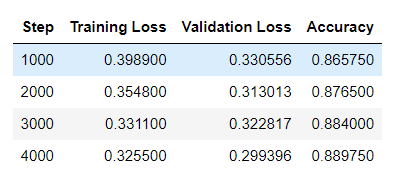

In [19]:
# 평가
trainer.evaluate(test_data)

***** Running Evaluation *****
  Num examples = 4000
  Batch size = 8


{'eval_loss': 0.2996222674846649,
 'eval_accuracy': 0.88925,
 'eval_runtime': 138.9893,
 'eval_samples_per_second': 28.779,
 'eval_steps_per_second': 3.597,
 'epoch': 1.0}